In [1]:
%matplotlib inline
import os
import sys
import random
import numpy as np
import ipyvolume.pylab as p3
import time
import matplotlib.pyplot as plt
import tensorflow as tf
import provider
import importlib
sys.path.append(os.path.join(".", 'models'))
sys.path.append(os.path.join(".", 'utils'))
import provider
import tf_util
from ipywidgets import interact,IntSlider
from tetgen_object import load_tetgen
from matplotlib import cm
max_groups = 20
colors = cm.coolwarm(np.linspace(0.0,1.0,max(2,max_groups)))[:,:3]

In [2]:
TEST_FILES = provider.getDataFiles("./data/test_files.txt")
BATCH_SIZE = 1
NUM_POINT = 2048
SMESH_DIR = "./Pottery_id_mesh/"
MODEL = importlib.import_module("dgcnn_pottery_seg")
WEIGHT_CLS = "log_cls8/model_39_0.08432036832104348_0.4223867771596353.ckpt"
WEIGHT_SEG = "log_seg3/model_29_0.05234326236279665_7.560962804710282.ckpt"

file:///home/keeyoung/CloudStation/AIRI/%EC%97%B0%EA%B5%AC/%EC%A0%95%EB%B6%80%EA%B3%BC%EC%A0%9C_%EB%8F%84%EC%9E%90%EA%B8%B0/1%EC%B0%A8%EB%85%84%EB%8F%84%20%EB%B3%B4%EA%B3%A0%EC%84%9C/%EC%97%B0%EC%B0%A8%EB%B3%B4%EA%B3%A0%EC%84%9C/model1.png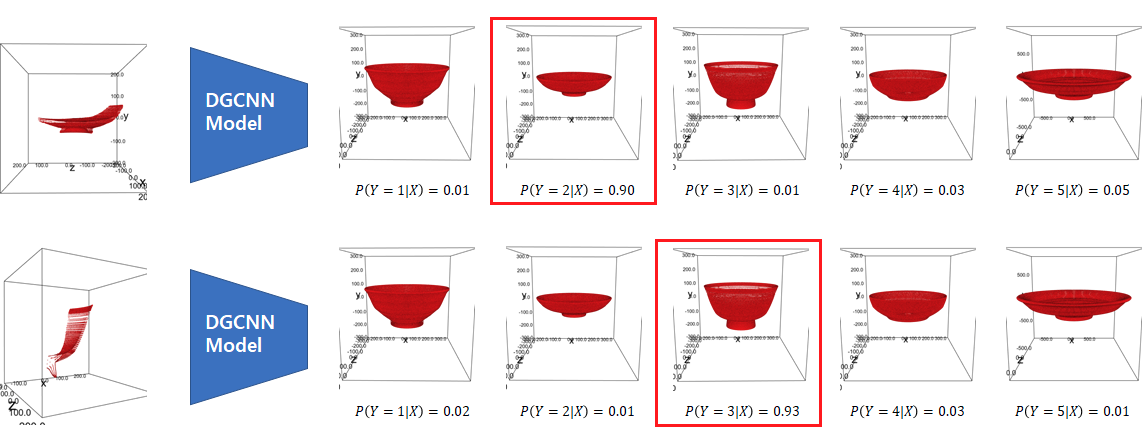

file:///home/keeyoung/CloudStation/AIRI/%EC%97%B0%EA%B5%AC/%EC%A0%95%EB%B6%80%EA%B3%BC%EC%A0%9C_%EB%8F%84%EC%9E%90%EA%B8%B0/1%EC%B0%A8%EB%85%84%EB%8F%84%20%EB%B3%B4%EA%B3%A0%EC%84%9C/%EC%97%B0%EC%B0%A8%EB%B3%B4%EA%B3%A0%EC%84%9C/model2.png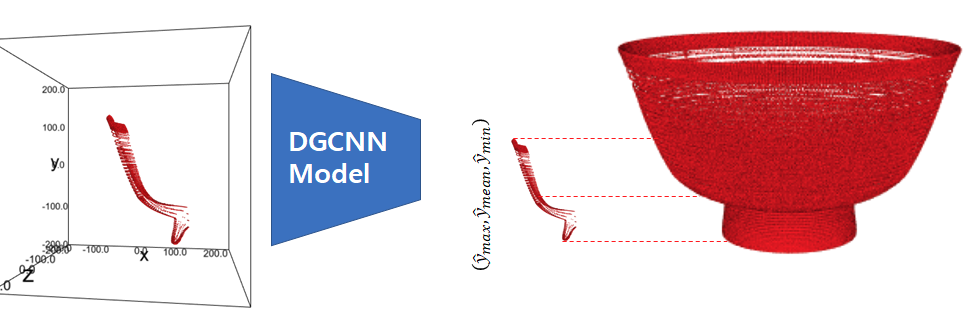

In [3]:
# placeholders
pointclouds_pl, labels_pl, labels_pl_c = MODEL.placeholder_inputs(BATCH_SIZE, NUM_POINT)
is_training_pl = tf.placeholder(tf.bool, shape=())

# Get model and loss
pred_c, pred, end_points = MODEL.get_model(pointclouds_pl, is_training_pl)
loss, cls_loss, cls_loss_c, reg_loss = MODEL.get_loss(pred, pred_c, labels_pl, labels_pl_c, end_points)

# # optimizer and trainer
# optimizer = tf.train.AdamOptimizer()
# optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, clip_norm=1.0)
# train_op = optimizer.minimize(loss, global_step=batch)

# saver
saver = tf.train.Saver()

# Create a session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
config.log_device_placement = False
sess = tf.Session(config=config)

# Init variables
init = tf.global_variables_initializer()
sess.run(init, {is_training_pl: True})

saver.restore(sess, WEIGHT_CLS)
#init_epoch = int(WEIGHT.split("_epoch")[1].split("_acc")[0])
init_epoch = 1
print("Model restored:", WEIGHT_CLS)
print("epoch:", init_epoch)

ops = {'pointclouds_pl': pointclouds_pl,
       'labels_pl': labels_pl,
       'labels_pl_c': labels_pl_c,
       'is_training_pl': is_training_pl,
       'pred': pred,
       'pred_c': pred_c,
       #'loss': loss,
       'cls_loss': cls_loss,
       'cls_loss_c': cls_loss_c,
       #'reg_loss': reg_loss,
       #'train_op': train_op,
       #'merged': merged,
       #'step': batch,
       #'filters': filters,
      }

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
dgcnn: Tensor("Max_4:0", shape=(1, 1, 1, 1024), dtype=float32)
reshape: Tensor("Reshape_10:0", shape=(1, 1024), dtype=float32)
skip_dense0:  Tensor("add_15:0", shape=(1, 1024), dtype=float32)
skip_dense1:  Tensor("add_16:0", shape=(1, 1024), dtype=float32)
skip_dense2:  Tensor("add_17:0", shape=(1, 1024), dtype=float32)
skip_dense3:  Tensor("add_18:0", shape=(1, 1024), dtype=float32)
skip_dense4:  Tensor("add_19:0", shape=(1, 1024), dtype=float32)
skip_dense5:  Tensor("add_20:0", shape=(1, 1024), dtype=float32)
skip_dense6:  Tensor("add_21:0", shape=(1, 1024), dtype=float32)
skip_dense7:  Tensor("add_22:0", shape=(1, 1024), dtype=float32)
skip_dense8:  Tensor("add_23:0", shape=(1, 1024), dtype=float32)
skip_dense9:  Tensor("add_24:0", shape=(1, 1024), dtype=float32)
INFO:tensorflow:Restoring parameters from log_cls8/model_39_0.084320368321043

In [4]:
@interact(idx=IntSlider(min=0,max=19,value=0,continuous_update=False), fn=TEST_FILES, draw=False)
def show_fracture(fn, idx, draw):

    global pot_id, shards, hashcode, data, label, seg
    data, label, seg = provider.loadsegDataFile(fn)
    #shards = int(fn.split('_')[1])
    pot_id, shards, hashcode = fn.split('_')
    pot_id = int(pot_id)
    shards = int(shards)
    hashcode = int(hashcode.split('.')[0])
    
    x,y,z = data[idx].transpose()
    
    # display the shard
    p3.figure()
    p3.scatter(x, -y, z, size=0.5, marker='sphere', color='grey')
    p3.squarelim()
    p3.show()
    
    # predict pottery id and placement of the given shard
    train_data = data[idx:idx+1]
    rs_seg = seg[idx:idx+1]
    current_label = label[idx:idx+1]
    rs_label = np.eye(5)[current_label]
    print(train_data.shape, rs_seg.shape, rs_label.shape)

    # data augmentation
    jittered_data = provider.rotate_perturbation_point_cloud(train_data, angle_sigma= np.pi/2, angle_clip = np.pi)
    jittered_data = provider.jitter_point_cloud(jittered_data)
    jittered_data = provider.random_scale_point_cloud(jittered_data)
    jittered_data = provider.shift_point_cloud(jittered_data)

    feed_dict = {ops['pointclouds_pl']: jittered_data,
                        ops['labels_pl']: rs_seg,
                        ops['labels_pl_c']: rs_label,
                        ops['is_training_pl']: False
                        }

    saver.restore(sess, WEIGHT_CLS)

    cls_loss_c, pred_c_val = sess.run([
                #ops['merged'],
                #ops['step'],
                #ops['train_op'],
                #ops['loss'],
                #ops['cls_loss'],
                ops['cls_loss_c'],
                #ops['reg_loss'],
                #ops['pred'],
                ops['pred_c'],
                ], feed_dict=feed_dict)


    #print('label:', seg)
    #print('pred:', pred_val)
    #print('cls_loss:', cls_loss)
    print('label_c:', current_label+1)
    print('pred_c:', np.argmax(pred_c_val, axis=1)+1)
    print('cls_loss_c:', cls_loss_c)

    saver.restore(sess, WEIGHT_SEG)

    cls_loss, pred_val = sess.run([
                #ops['merged'],
                #ops['step'],
                #ops['train_op'],
                #ops['loss'],
                ops['cls_loss'],
                #ops['cls_loss_c'],
                #ops['reg_loss'],
                ops['pred'],
                #ops['pred_c'],
                ], feed_dict=feed_dict)


    print('label:', rs_seg[0])
    print('pred:', pred_val[0])
    print('cls_loss:', cls_loss)
    #print('label_c:', current_label)
    #print('pred_c:', np.argmax(pred_c_val, axis=1))
    #print('cls_loss_c:', cls_loss_c)
    
    heat_map = [[1,1,0],
            [1,1,0],
            [1,0.875,0],
            [1,0.75,0],
            [1,0.625,0],
            [1,0.5,0],
            [1,0.375,0],
            [1,0.25,0],
            [1,0.125,0],
            [1,0,0]]  # R,G,B

    if draw == True:
        #tetgen_obj = load_tetgen('/data1/DATA/Pottery_10000/outputs'+str(pot_id)+'/generated_'+str(shards)+'_0_'+str(hashcode)+'.1')
        tetgen_obj = load_tetgen(SMESH_DIR+'pot0'+str(pot_id))
        x, y, z = tetgen_obj.nodes.points.transpose()
        triangles = tetgen_obj.faces.faces

        min_y, max_y = np.amin(y), np.amax(y)
        diff_y = max_y - min_y
        print("min_y, max_y, diff_y:", min_y, max_y, diff_y)
        rs_seg = rs_seg[0]
        pred_val = pred_val[0]
        upper_area = pred_val[0] - pred_val[1]
        lower_area = pred_val[1] - pred_val[2]
        print("upper and lower area:", upper_area, lower_area)

        lw = 0.005
        cc = np.zeros([y.shape[0], 3])
        #cc[:,2] = 1
        cc[:] = cc[:] + [0.3, 0.3, 0.3]
        print(cc.shape, cc[0])
        for pt in range(y.shape[0]):
            st_y = (y[pt] - min_y) / diff_y
            if st_y > rs_seg[0] - lw and st_y < rs_seg[0] + lw:
                cc[pt] = [0,0,1]  # Blue line
            elif st_y > rs_seg[1] - lw and st_y < rs_seg[1] + lw:
                cc[pt] = [0,0,1]  # Blue line
            elif st_y > rs_seg[2] - lw and st_y < rs_seg[2] + lw:
                cc[pt] = [0,0,1]  # Blue line
            elif st_y > pred_val[0]:  # over the shard area
                cc[pt] = [0.3,0.3,0.3]  # Grey
            elif st_y > pred_val[0] - upper_area/11:
                cc[pt] = heat_map[0]
            elif st_y > pred_val[0] - upper_area*2/11:
                cc[pt] = heat_map[1]
            elif st_y > pred_val[0] - upper_area*3/11:
                cc[pt] = heat_map[2]
            elif st_y > pred_val[0] - upper_area*4/11:
                cc[pt] = heat_map[3]
            elif st_y > pred_val[0] - upper_area*5/11:
                cc[pt] = heat_map[4]
            elif st_y > pred_val[0] - upper_area*6/11:
                cc[pt] = heat_map[5]
            elif st_y > pred_val[0] - upper_area*7/11:
                cc[pt] = heat_map[6]
            elif st_y > pred_val[0] - upper_area*8/11:
                cc[pt] = heat_map[7]
            elif st_y > pred_val[0] - upper_area*9/11:
                cc[pt] = heat_map[8]
            elif st_y > pred_val[0] - upper_area*10/11:
                cc[pt] = heat_map[9]            
            elif st_y > pred_val[2] + lower_area*9/10:
                cc[pt] = heat_map[8]
            elif st_y > pred_val[2] + lower_area*8/10:
                cc[pt] = heat_map[7]
            elif st_y > pred_val[2] + lower_area*7/10:
                cc[pt] = heat_map[6]
            elif st_y > pred_val[2] + lower_area*6/10:
                cc[pt] = heat_map[5]
            elif st_y > pred_val[2] + lower_area*5/10:
                cc[pt] = heat_map[4]
            elif st_y > pred_val[2] + lower_area*4/10:
                cc[pt] = heat_map[3]
            elif st_y > pred_val[2] + lower_area*3/10:
                cc[pt] = heat_map[2]
            elif st_y > pred_val[2] + lower_area*2/10:
                cc[pt] = heat_map[1]
            elif st_y >= pred_val[2] + lower_area/10:
                cc[pt] = heat_map[0]
            elif st_y < pred_val[2]:  # under the shard area
                cc[pt] = [0.3,0.3,0.3]  # Grey


        p3.figure()
        p3.plot_trisurf(x, -y, z, triangles=triangles, color=cc)
        p3.squarelim()
        p3.show()

interactive(children=(Dropdown(description='fn', options=('2_20_496528.h5', '4_16_643996.h5', '4_18_443634.h5'…